---
title: "Structure plot from GWAS phenotypes"
author: "Saikat Banerjee"
format:
  html: default
date: "2023-10-23"
file-modified: "2023-10-24"
abstract: "Our goal is to create a structure plot from the PCA. 
We obtain low rank approximation of the GWAS summary statistics data using the three methods we have developed till date.
We manually label each GWAS with a broad phenotype. 
We perform PCA on the approximated low rank matrix and analyze the clustering of the data 
by comparing with the curated phenotype labels."

---

# Getting Setup

In [1]:
import numpy as np
import pandas as pd
import pickle
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120, colors = 'kelly')

from nnwmf.optimize import IALM
from nnwmf.optimize import FrankWolfe, FrankWolfe_CV
from nnwmf.utils import model_errors as merr

import sys
sys.path.append("../utils/")
import histogram as mpy_histogram
import simulate as mpy_simulate
import plot_functions as mpy_plotfn

# Loading data

In [2]:
data_dir = "../data"
beta_df_filename   = f"{data_dir}/beta_df.pkl"
prec_df_filename   = f"{data_dir}/prec_df.pkl"
se_df_filename     = f"{data_dir}/se_df.pkl"
zscore_df_filename = f"{data_dir}/zscore_df.pkl"
snp_info_filename  = f"{data_dir}/snp_info.pkl"

'''
Data Frames for beta, precision, standard error and zscore.
'''

beta_df   = pd.read_pickle(beta_df_filename)
prec_df   = pd.read_pickle(prec_df_filename)
se_df     = pd.read_pickle(se_df_filename)
zscore_df = pd.read_pickle(zscore_df_filename)
snp_info  = pd.read_pickle(snp_info_filename)

trait_df = pd.read_csv(f"{data_dir}/trait_meta.csv")
phenotype_dict = trait_df.set_index('ID')['Broad'].to_dict()

In [3]:
zscore_df

,AD_sumstats_Jansenetal_2019sept.txt.gz,CNCR_Insomnia_all,GPC-NEO-NEUROTICISM,IGAP_Alzheimer,Jones_et_al_2016_Chronotype,Jones_et_al_2016_SleepDuration,MDD_MHQ_BIP_METACARPA_INFO6_A5_NTOT_no23andMe_...,MDD_MHQ_METACARPA_INFO6_A5_NTOT_no23andMe_noUK...,MHQ_Depression_WG_MAF1_INFO4_HRC_Only_Filtered...,MHQ_Recurrent_Depression_WG_MAF1_INFO4_HRC_Onl...,...,ieu-b-7,ieu-b-8,ieu-b-9,ocd_aug2017.txt.gz,pgc-bip2021-BDI.vcf.txt.gz,pgc-bip2021-BDII.vcf.txt.gz,pgc-bip2021-all.vcf.txt.gz,pgc.scz2,pgcAN2.2019-07.vcf.txt.gz,pts_all_freeze2_overall.txt.gz
rs1000031,-0.999531,-0.327477,1.241557,0.441709,-0.163658,0.163658,-0.336654,-0.793129,-1.075357,-2.182304,...,0.532189,NaN,NaN,-0.198735,1.057089,-0.269020,1.279776,-0.433158,-1.573766,-1.674269
rs1000269,-1.212805,-1.046310,0.741814,-1.844296,-2.673787,-1.126391,0.092067,0.163246,1.643581,2.122280,...,1.665179,-0.732000,-0.699000,0.100883,-0.226381,0.338368,-0.924392,0.832016,0.681645,-0.701776
rs10003281,-0.813444,2.034345,-1.750164,-0.076778,-0.954165,1.805477,NaN,NaN,NaN,NaN,...,-0.475795,4.437998,2.366001,0.967399,0.286699,-1.162661,-0.199299,0.014539,NaN,-1.379710
rs10004866,0.011252,1.327108,1.442363,-1.215173,-0.050154,-1.439531,2.458370,2.407460,-0.001038,-1.678331,...,-1.234375,-2.520001,-0.593997,-0.685110,0.902252,1.106939,1.776456,-1.654677,-0.964630,0.851608
rs10005235,0.612540,-0.410609,0.653087,0.344062,-2.183486,1.514102,-0.460191,-0.393006,1.015614,0.180744,...,0.387805,-0.345000,-0.960998,0.177317,-1.339598,1.795867,-1.249969,2.349671,0.996305,-0.333356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rs9989571,0.028306,-0.208891,0.366470,0.821257,0.453762,-1.895698,0.218149,0.920789,1.581000,1.121551,...,-1.231511,-0.820996,0.712000,-2.150176,-0.877410,-1.938969,-2.729983,3.207917,1.469194,-1.293122
rs9991694,-0.679790,-1.005571,0.753472,-0.539271,1.674665,-2.862736,-3.744820,-3.583060,-4.072853,-2.804192,...,0.064417,NaN,NaN,-2.884911,-1.000231,0.031860,-1.248222,2.309425,NaN,1.048454
rs9992763,0.691405,-0.010299,-0.140010,-0.419843,-0.138304,0.568052,0.019684,-0.194404,0.869694,0.061210,...,0.191860,-0.074000,1.030997,-0.228287,-0.051297,0.781766,0.010638,0.456681,-0.503370,-1.435277
rs9993607,-1.625392,-0.391585,0.514268,0.027576,0.150969,-0.113039,-4.638940,-4.631950,-2.918354,-2.204015,...,-0.685106,0.194000,0.240001,-0.790290,-0.876804,-0.577696,-0.785670,-0.062707,0.240834,-0.199740


In [4]:
#| code-fold: false

X_nan = np.array(zscore_df).T
X_nan_cent = X_nan - np.nanmean(X_nan, axis = 0, keepdims = True)
X_nan_mask = np.isnan(X_nan)
X_cent = np.nan_to_num(X_nan_cent, copy = True, nan = 0.0)

print (f"We have {X_cent.shape[0]} samples (phenotypes) and {X_cent.shape[1]} features (variants)")
print (f"Fraction of Nan entries: {np.sum(X_nan_mask) / np.prod(X_cent.shape):.3f}")

We have 69 samples (phenotypes) and 10068 features (variants)
Fraction of Nan entries: 0.193


In [5]:
#| code-fold: false

select_ids = zscore_df.columns
labels = [phenotype_dict[x] for x in select_ids]
unique_labels = list(set(labels))
nsample = X_cent.shape[0]
ntrait  = len(unique_labels)

trait_indices = [np.array([i for i, x in enumerate(labels) if x == label]) for label in unique_labels]
trait_colors  = {trait: color for trait, color in zip(unique_labels, (mpl_stylesheet.kelly_colors())[:ntrait])}

We perform PCA (using SVD) on the raw input data (mean centered). In @fig-input-pca-pve, we look at the proportion of variance explained by each principal component. 

# Low rank matrices

We have run 3 different methods to obtain low rank matrices, namely IALM, NNM and NNM-Sparse. Here, we load the results from those methods.

In [6]:
mf_methods = ['ialm', 'nnm', 'nnm_sparse']
lowrank_X = dict()

for method in mf_methods:
    with open (f"{data_dir}/lowrank_X_{method}.pkl", 'rb') as handle:
        lowrank_X[method] = pickle.load(handle)

# Principal components

Suppose, we decompose $\mathbf{X} = \mathbf{U}\mathbf{S}\mathbf{V}^{\intercal}$. 
Columns of $\mathbf{V}$ are the principal axes (aka principal directions, aka eigenvectors). 
The principal components are the columns of $\mathbf{U}\mathbf{S}$ -- the projections of the data on the the principal axes 
(note $\mathbf{X}\mathbf{V} = \mathbf{U}\mathbf{S}$).

In [7]:
def get_principal_components(X):
    X_cent = mpy_simulate.do_standardize(X, scale = False)
    X_cent /= np.sqrt(np.prod(X_cent.shape))
    U, S, Vt = np.linalg.svd(X_cent, full_matrices = False)
    pcomps = U @ np.diag(S)
    loadings = Vt.T @ np.diag(S)
    return loadings, pcomps, S

loadings  = dict()
pcomps    = dict()
eigenvals = dict()

loadings['tsvd'], pcomps['tsvd'], eigenvals['tsvd'] = get_principal_components(X_cent)
for m in mf_methods:
    loadings[m], pcomps[m], eigenvals[m] = get_principal_components(lowrank_X[m])

In @fig-scree-plots, we look at the eigenvalues obtained from PCA of the low rank matrices. 
The first plot on the left shows the PCA on the raw data, without noise removal.
It is evident that a truncated SVD (as shown below) will not be able to capture the variance in the data.

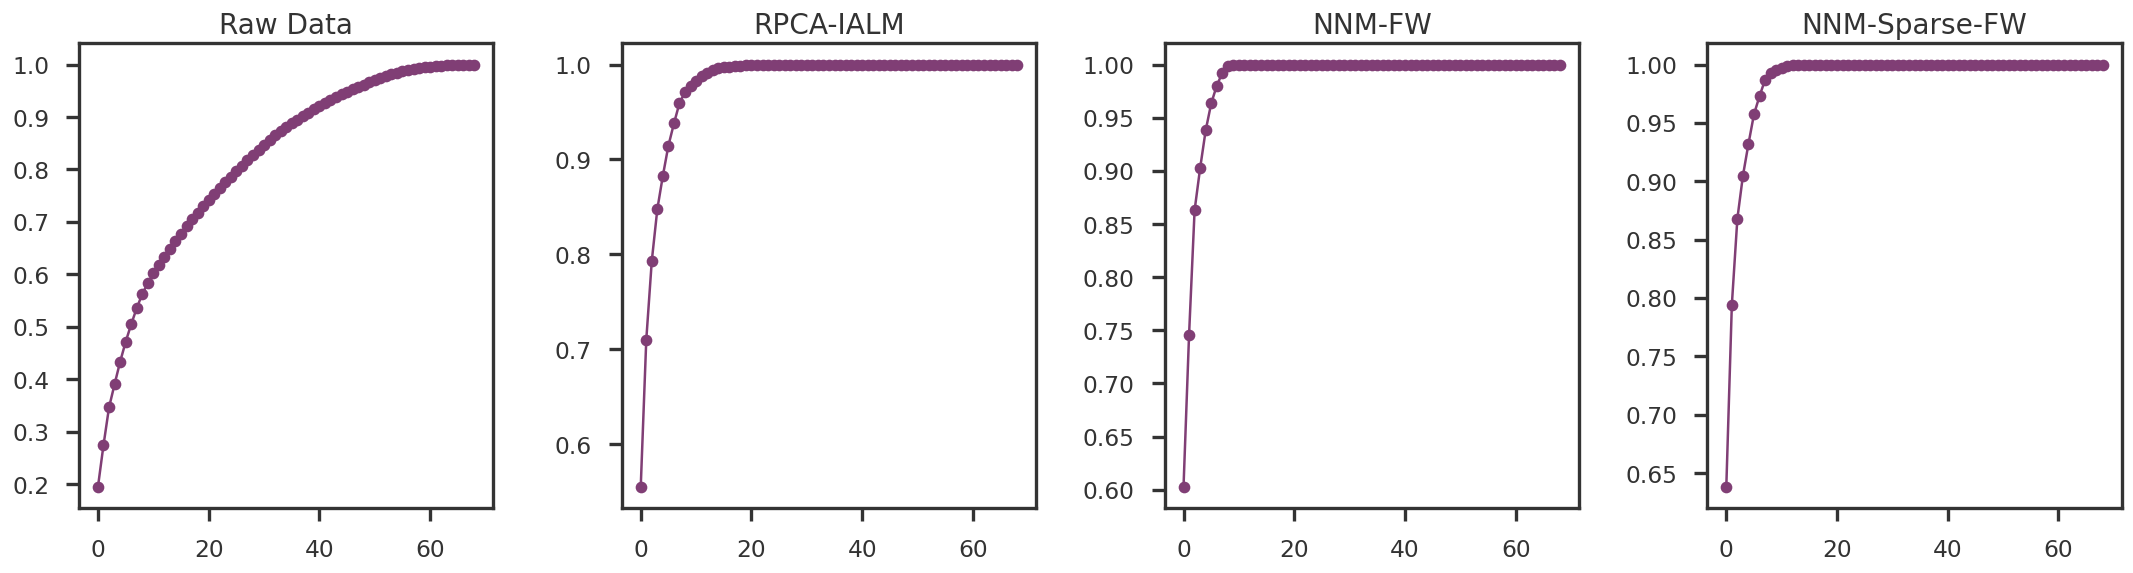

In [8]:
#| label: fig-scree-plots
#| fig-cap: "Scree plots from PCA of low rank matrices"

plot_methods = ['tsvd'] + mf_methods
plot_methods_names = {
    'tsvd' : 'Raw Data',
    'ialm' : 'RPCA-IALM',
    'nnm'  : 'NNM-FW',
    'nnm_sparse' : 'NNM-Sparse-FW',
}

fig = plt.figure(figsize=(18, 5))
ax = [None for i in range(len(plot_methods))]

for i, m in enumerate(plot_methods):
    ax[i] = fig.add_subplot(1, len(plot_methods), i+1)
    S = eigenvals[m]
    S2 = np.square(S)
    ax[i].plot(np.arange(S.shape[0]), np.cumsum(S2 / np.sum(S2)), 'o-')
    ax[i].set_title(plot_methods_names[m])

plt.tight_layout(w_pad = 2)
plt.show()

# Contribution of principal components on phenotypes

We look at the contribution of the loadings on the phenotypes using structure plot.
The importance of a principal component is reflected by its inertia 
or by the proportion of the total inertia "explained" by this factor.
We can calculate the contribution of an observation to the component
or the contribution of the component to an observation.

Suppose, the principal components are $\mathbf{F} = \mathbf{U}\mathbf{S}$.
Then, the squared cosine shows the importance of a component for a given observation.
$$\cos_{i, l}^2 = \frac{f_{i,l}^2}{\sum_{l}f_{i,l}^2}$$

Intuitively, the above factor corresponds to the square of the cosine of the angle
from the right triangle made with the origin, the observation and its projection on the component.

[See better explanation](https://personal.utdallas.edu/~herve/abdi-awPCA2010.pdf)

In [9]:
def get_cos2_scores(pcomps):
    ntrait, npcomp = pcomps.shape
    x = np.zeros((ntrait, npcomp))
    for i in range(ntrait):
        cos2_trait = np.array([np.square(pcomps[i, pcidx]) for pcidx in range(npcomp)])
        x[i, :] = cos2_trait / np.sum(cos2_trait)
    return x

def stacked_barplot(ax, data, xlabels, colors, bar_width = 1.0, alpha = 1.0, showxlabels = False):
    '''
    Parameters
    ----------
        data: 
            dict() of scores. 
            - <key> : items for the stacked bars (e.g. traits or components)
            - <value> : list of scores for the items. All dict entries must have the same length of <value>
        xlabels: 
            label for each entry in the data <value> list. Must be of same length of data <value>
        colors: 
            dict(<key>, <color>) corresponding to each data <key>.
    '''
    indices = np.arange(len(xlabels))
    bottom = np.zeros(len(xlabels))

    for item, weights in data.items():
        ax.bar(indices, weights, bar_width, label = item, bottom = bottom, color = colors[item], alpha = alpha)
        bottom += weights

    if showxlabels:
        ax.set_xticks(indices)
        ax.set_xticklabels(xlabels, rotation=90, ha='center')
        ax.tick_params(bottom = True, top = False, left = False, right = False,
                   labelbottom = True, labeltop = False, labelleft = False, labelright = False)
    else:
        ax.tick_params(bottom = False, top = False, left = False, right = False,
                   labelbottom = False, labeltop = False, labelleft = False, labelright = False)

    for side, border in ax.spines.items():
        border.set_visible(False)

    return


def structure_plot(ax, pcomps, trait_labels, comp_colors, npcomp, showxlabels = False):
    cos2_scores = get_cos2_scores(pcomps)[:, :npcomp]
    cos2_plot_data = {
        f"{i+1}" : cos2_scores[:, i] for i in range(npcomp)
    }
    stacked_barplot(ax, cos2_plot_data, trait_labels, comp_colors, alpha = 0.8, showxlabels = showxlabels)
    return

In @fig-pcomp-contribution-to-phenotype, we look at the contribution of the **top 10** principal components to the disease phenotypes.

In [25]:
phenotype_dict_readable = {
    'AD_sumstats_Jansenetal_2019sept.txt.gz' : 'AD_Jansen_2019',
    'anxiety.meta.full.cc.txt.gz' : 'anxiety',
    'anxiety.meta.full.fs.txt.gz' : 'anxiety',
    'CNCR_Insomnia_all' : 'Insomnia',
    'daner_adhd_meta_filtered_NA_iPSYCH23_PGC11_sigPCs_woSEX_2ell6sd_EUR_Neff_70.txt.gz' : 'ADHD_Daner',
    'daner_PGC_BIP32b_mds7a_0416a.txt.gz' : 'BD_Daner_PGC',
    'daner_PGC_BIP32b_mds7a_mds7a_BD1.0416a_INFO6_A5_NTOT.txt.gz' : 'BD1_Daner_PGC',
    'daner_PGC_BIP32b_mds7a_mds7a_BD2.0416a_INFO6_A5_NTOT.txt.gz' : 'BD2_Daner_PGC',
    'ENIGMA_Intracraneal_Volume' : 'Intracraneal_Volume',
    'ieu-a-1000' : 'Neuroticism',
    'ieu-a-1041' : 'Intracranial volume',
    'ieu-a-1042' : 'Nucleus accumbens volume',
    'ieu-a-1043' : 'Amygdala volume',
    'ieu-a-1044' : 'Caudate volume',
    'ieu-a-1045' : 'Hippocampus volume',
    'ieu-a-1046' : 'Pallidum volume',
    'ieu-a-1047' : 'Putamen volume',
    'ieu-a-1048' : 'Thalamus volume',
    'ieu-a-1085' : 'Amyotrophic lateral sclerosis',
    'ieu-a-118' : 'Neuroticism',
    'ieu-a-1183' : 'ADHD',
    'ieu-a-1184' : 'Autism Spectrum Disorder',
    'ieu-a-1185' : 'Autism Spectrum Disorder',
    'ieu-a-1186' : 'Anorexia Nervosa',
    'ieu-a-1188' : 'Major Depressive Disorder',
    'ieu-a-1189' : 'Obsessive Compulsive Disorder',
    'ieu-a-22' : 'Schizophrenia',
    'ieu-a-297' : 'Alzheimers disease',
    'ieu-a-806' : 'Autism',
    'ieu-a-990' : 'Bulimia nervosa',
    'ieu-b-10' : 'Focal epilepsy',
    'ieu-b-11' : 'Focal epilepsy',
    'ieu-b-12' : 'Juvenile absence epilepsy',
    'ieu-b-13' : 'Childhood absence epilepsy',
    'ieu-b-14' : 'Focal epilepsy',
    'ieu-b-15' : 'Focal epilepsy',
    'ieu-b-16' : 'Generalized epilepsy',
    'ieu-b-17' : 'Juvenile myoclonic epilepsy',
    'ieu-b-18' : 'Multiple sclerosis',
    'ieu-b-2' : 'Alzheimers disease',
    'ieu-b-41' : 'Bipolar Disorder',
    'ieu-b-42' : 'Schizophrenia',
    'ieu-b-7' : 'Parkinsons',
    'ieu-b-8' : 'Epilepsy',
    'ieu-b-9' : 'Generalized epilepsy',
    'IGAP_Alzheimer' : 'IGAP_Alzheimer',
    'iPSYCH-PGC_ASD_Nov2017.txt.gz' : 'ASD_PGC_Nov2017',
    'Jones_et_al_2016_Chronotype' : 'Chronotype_Jones_2016',
    'Jones_et_al_2016_SleepDuration' : 'Sleep_duration_Jones_2016',
    'MDD_MHQ_BIP_METACARPA_INFO6_A5_NTOT_no23andMe_noUKBB.txt.gz' : 'MDD_BIP_no23andMe_noUKBB',
    'MDD_MHQ_METACARPA_INFO6_A5_NTOT_no23andMe_noUKBB.txt.gz' : 'MDD_METACARPA_no23andMe_noUKBB',
    'MHQ_Depression_WG_MAF1_INFO4_HRC_Only_Filtered_Dups_FOR_METACARPA_INFO6_A5_NTOT.txt.gz' : 'Depression',
    'MHQ_Recurrent_Depression_WG_MAF1_INFO4_HRC_Only_Filtered_Dups_FOR_METACARPA_INFO6_A5_NTOT.txt.gz' : 'Recurrent_Depression',
    'MHQ_Single_Depression_WG_MAF1_INFO4_HRC_Only_Filtered_Dups_FOR_METACARPA_INFO6_A5_NTOT.txt.gz' : 'Single_Depression',
    'MHQ_Subthreshold_WG_MAF1_INFO4_HRC_Only_Filtered_Dups_FOR_METACARPA_INFO6_A5_NTOT.txt.gz' : 'Subthreshold_WG',
    'ocd_aug2017.txt.gz' : 'OCD_aug2017',
    'PGC_ADHD_EUR_2017' : 'ADHD_PGC_EUR_2017',
    'PGC_ASD_2017_CEU' : 'ASD_PGC_2017_CEU',
    'pgc-bip2021-all.vcf.txt.gz' : 'BD_PGC_all_2021',
    'pgc-bip2021-BDI.vcf.txt.gz' : 'BDI_PGC_2021',
    'pgc-bip2021-BDII.vcf.txt.gz' : 'BDII_PGC_2021',
    'pgc.scz2' : 'Schizophrenia_PGC_2',
    'PGC3_SCZ_wave3_public.v2.txt.gz' : 'Schizophrenia_PGC_3',
    'pgcAN2.2019-07.vcf.txt.gz' : 'pgcAN2.2019-07.vcf.txt.gz',
    'pts_all_freeze2_overall.txt.gz' : 'pts_all_freeze2',
    'SSGAC_Depressive_Symptoms' : 'SSGAC_Depressive_Symptoms',
    'SSGAC_Education_Years_Pooled' : 'SSGAC_Education_Years_Pooled',
    'UKB_1160_Sleep_duration' : 'UKB_1160_Sleep_duration',
    'UKB_1180_Morning_or_evening_person_chronotype' : 'UKB_1180_Morning_or_evening_person_chronotype',
    'UKB_1200_Sleeplessness_or_insomnia' : 'UKB_1200_Sleeplessness_or_insomnia',
    'UKB_20002_1243_self_reported_psychological_or_psychiatric_problem' : 'UKB_20002_1243_self_reported_psychological_or_psychiatric_problem',
    'UKB_20002_1262_self_reported_parkinsons_disease' : 'UKB_20002_1262_self_reported_parkinsons_disease',
    'UKB_20002_1265_self_reported_migraine' : 'UKB_20002_1265_self_reported_migraine',
    'UKB_20002_1289_self_reported_schizophrenia' : 'UKB_20002_1289_self_reported_schizophrenia',
    'UKB_20002_1616_self_reported_insomnia' : 'UKB_20002_1616_self_reported_insomnia',
    'UKB_20016_Fluid_intelligence_score' : 'UKB_20016_Fluid_intelligence_score',
    'UKB_20127_Neuroticism_score' : 'UKB_20127_Neuroticism_score',
    'UKB_G40_Diagnoses_main_ICD10_G40_Epilepsy' : 'UKB_G40_Diagnoses_main_ICD10_G40_Epilepsy',
    'UKB_G43_Diagnoses_main_ICD10_G43_Migraine' : 'UKB_G43_Diagnoses_main_ICD10_G43_Migraine',
    'ieu-b-5070' : 'Schizophrenia',
    'GPC-NEO-NEUROTICISM' : 'GPC-NEO-NEUROTICISM',
    'ieu-a-1009' : 'Subjective well being',
    'ieu-a-1018' : 'Subjective well being',
    'ieu-a-1019' : 'Migraine in bipolar disorder',
    'ieu-a-1029' : 'Internalizing problems',
    'ieu-a-1061' : 'G speed factor',
    'ieu-a-1062' : 'Symbol search',
    'ieu-a-1063' : '8-choice reaction time',
    'ieu-a-1064' : '2-choice reaction time',
    'ieu-a-1065' : 'Inspection time',
    'ieu-a-1066' : 'Simple reaction time',
    'ieu-a-1067' : 'Digit symbol',
    'ieu-a-1068' : '4-choice reaction time',
    'ieu-a-45' : 'Anorexia nervosa',
    'ieu-a-298' : 'Alzheimers Disease',
    'ieu-a-808' : 'Bipolar Disorder',
    'ieu-a-810' : 'Schizophrenia',
    'ieu-a-812' : 'Parkinsons',
    'ieu-a-818' : 'Parkinsons',
    'ieu-a-824' : 'Alzheimers Disease',
    'ieu-b-43' : 'frontotemporal dementia',
    'ILAE_Genetic_generalised_epilepsy' : 'ILAE_Genetic_generalised_epilepsy'
}

labels_readable = [phenotype_dict_readable[x] for x in select_ids]

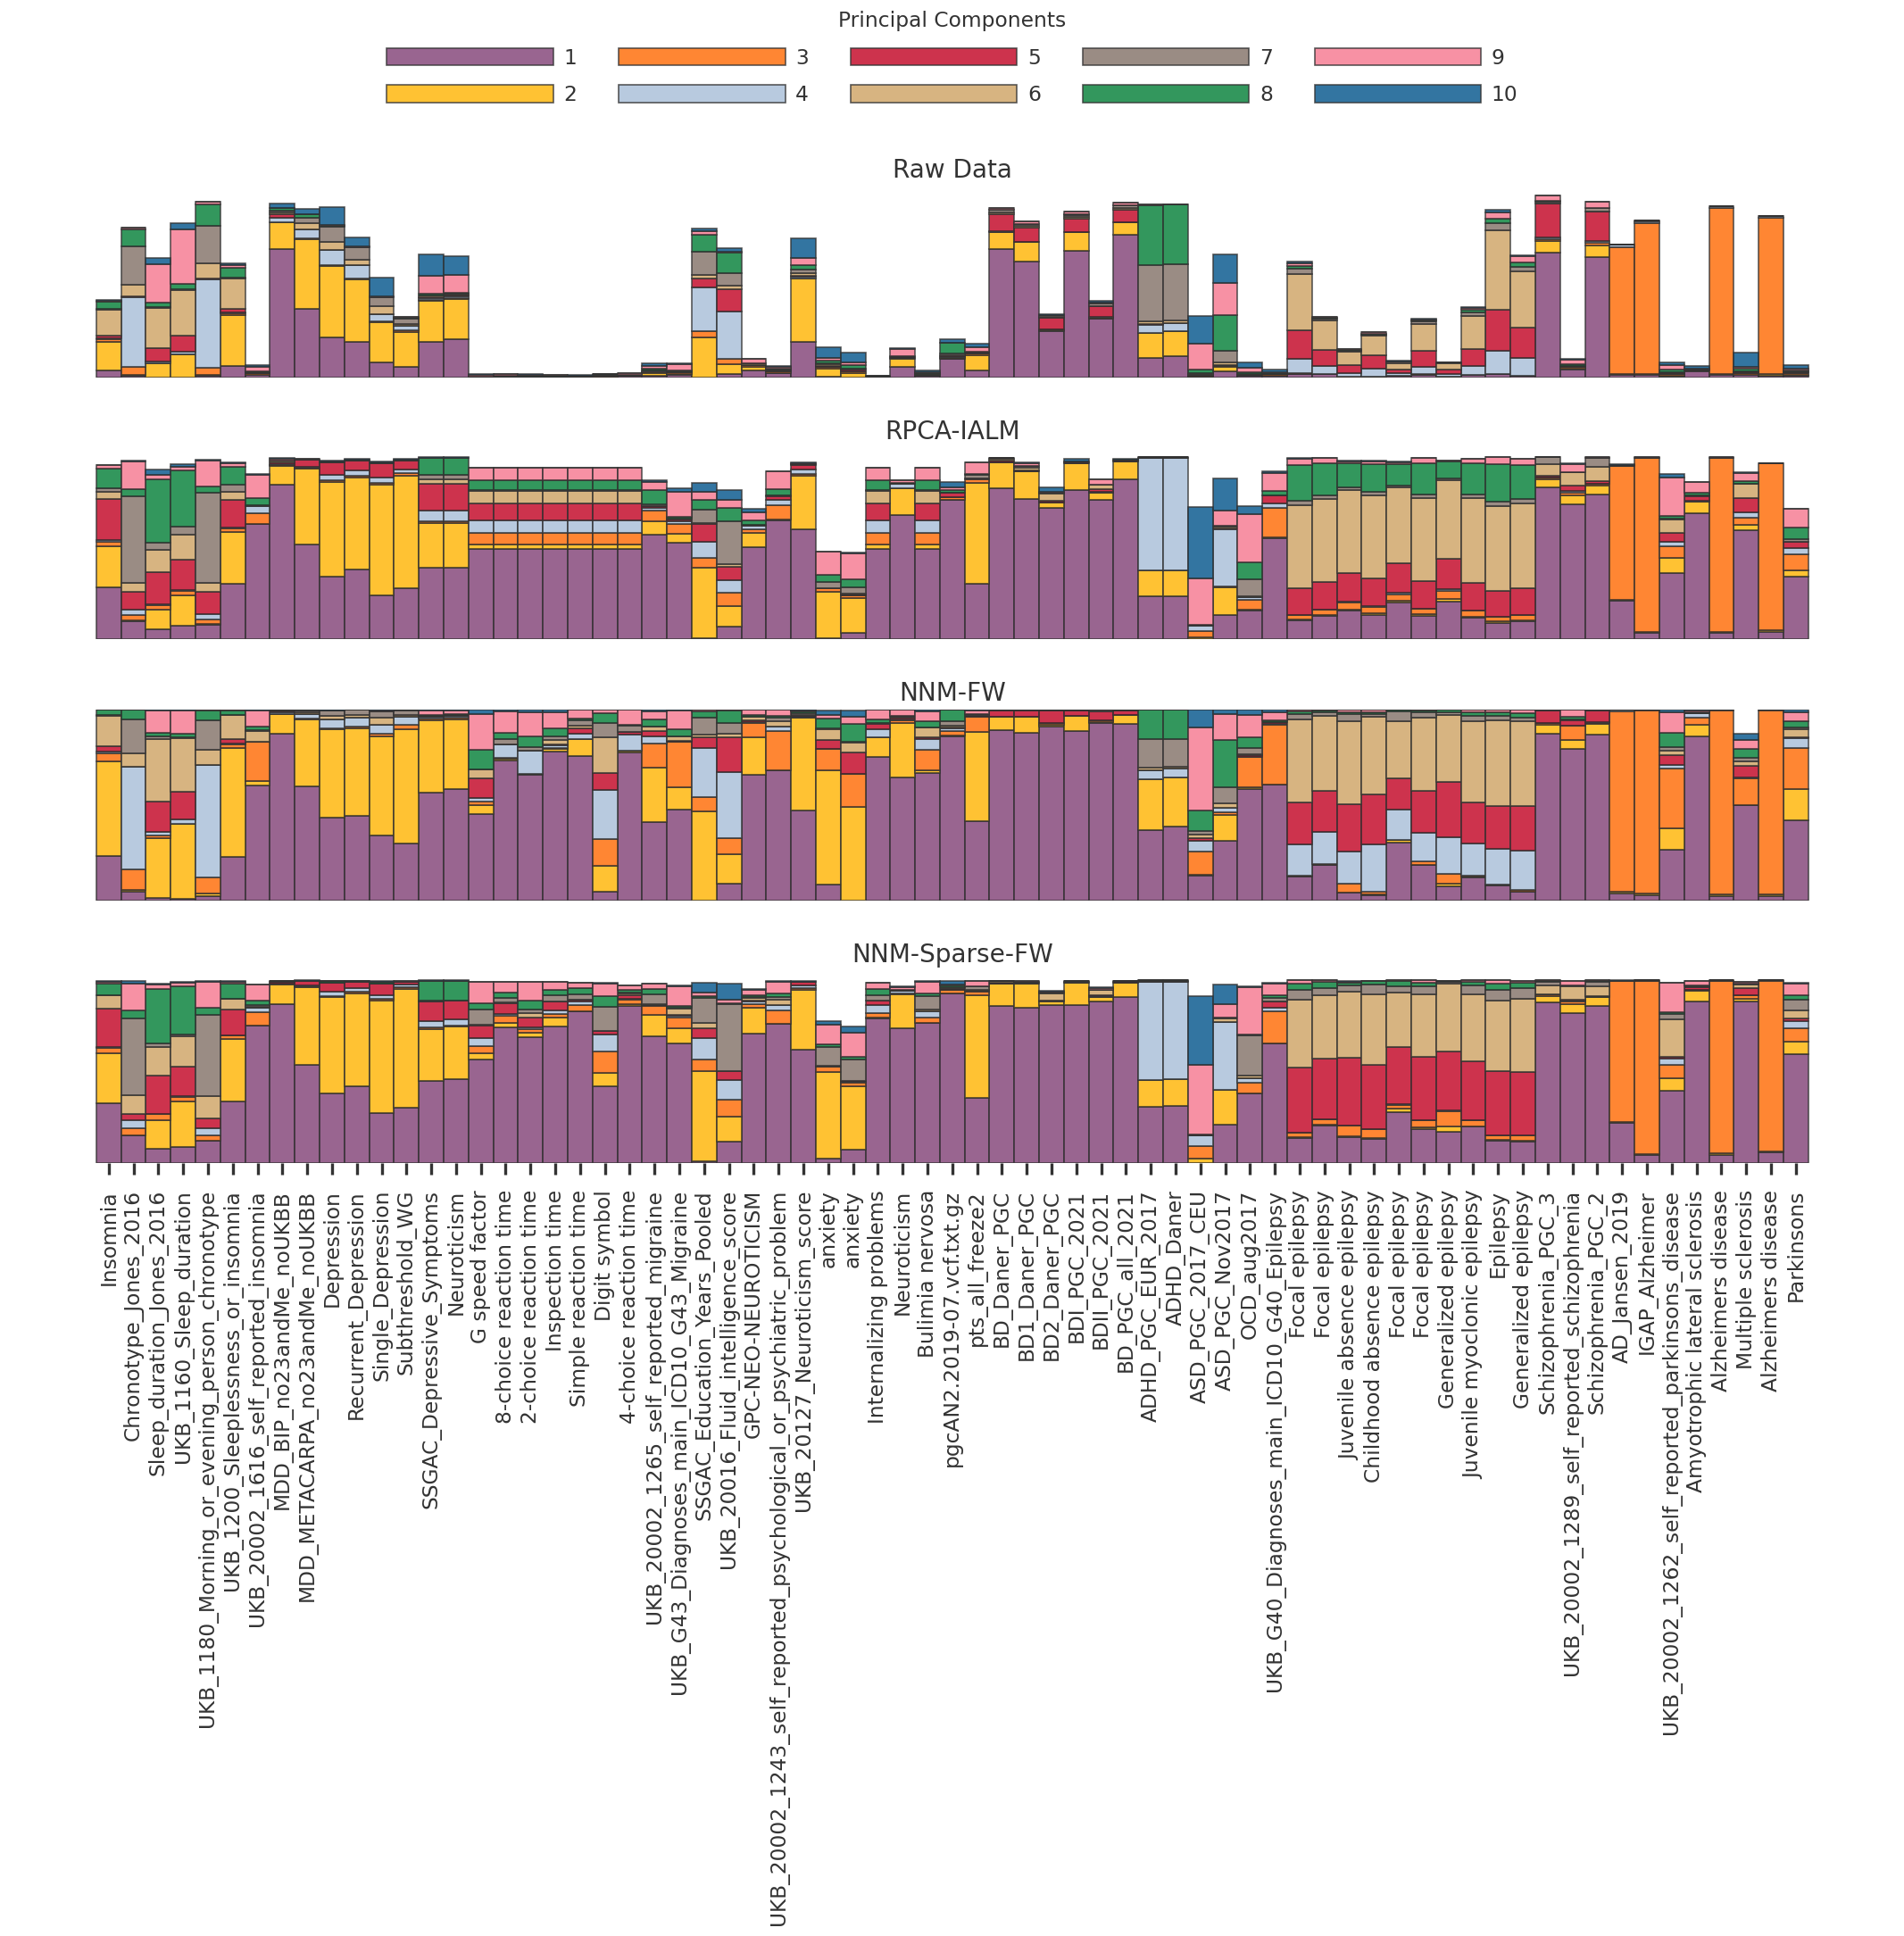

In [26]:
#| label: fig-pcomp-contribution-to-phenotype
#| fig-cap: "Contribution of each principal component to phenotypes"

"""
Number of components to plot
"""
npcomp = 10
    
"""
Sort the traits / phenotypes
"""
trait_indices_sorted = list()
for idx in trait_indices:
    trait_indices_sorted += list(idx)

trait_labels_sorted = [labels_readable[i] for i in trait_indices_sorted]
pcomp_colors  = {f"{i+1}": color for i, color in enumerate(mpl_stylesheet.kelly_colors() + mpl_stylesheet.banskt_colors())}
    
fig = plt.figure(figsize = (18, 18))
gs = GridSpec(nrows = len(plot_methods) + 1, ncols=1, figure=fig, height_ratios=[0.3] + [1 for i in plot_methods])
ax = [None for i in range(len(plot_methods) + 1)]
ax[0] = fig.add_subplot(gs[0, 0])

for i, m in enumerate(plot_methods):
    iplot = i + 1
    showxlabels = True if iplot == len(plot_methods) else False
    ax[iplot] = fig.add_subplot(gs[iplot, 0])
    structure_plot(ax[iplot], pcomps[m][trait_indices_sorted,:], trait_labels_sorted, pcomp_colors, npcomp, showxlabels = showxlabels)
    ax[iplot].set_title(plot_methods_names[m])
    
plt_handles, plt_labels = ax[i].get_legend_handles_labels()
ax[0].legend(plt_handles, plt_labels, 
             loc = 'lower center', bbox_to_anchor=(0.5, 0), title = "Principal Components",
             frameon = False, handlelength = 8, ncol = 5)
for side, border in ax[0].spines.items():
    border.set_visible(False)
ax[0].tick_params(bottom = False, top = False, left = False, right = False,
                   labelbottom = False, labeltop = False, labelleft = False, labelright = False)

#legend(bbox_to_anchor=(1.04, 1), loc="upper left")

plt.tight_layout(h_pad = 2.0)
plt.show()

# Which SNPs are associated with the principal components (hidden factors)?

In [11]:
def get_corrmat(pcomps, x, ncomp = None):
    if ncomp is None:
        ncomp = pcomps.shape[1]
    nvar  = x.shape[1]
    corr  = np.zeros((nvar, ncomp))
    pval  = np.zeros((nvar, ncomp))
    for ivar in range(nvar):
        d1 = x[:, ivar]
        for icomp in range(ncomp):
            d2 = pcomps[:, icomp]
            corr[ivar, icomp], pval[ivar, icomp] = pearsonr(d1, d2)
    return corr, pval

In [12]:
'''
Calculate the correlations and pvals, if required.
This takes time, so the pre-computed results can also be loaded from saved files
'''
corrs = dict()
pvals = dict()

# for m in plot_methods:
#     corrs[m], pvals[m] = get_corrmat(pcomps[m], X_cent, ncomp = 20)
#     with open (f"{data_dir}/loading_corr_{m}.pkl", 'wb') as handle:
#         pickle.dump(corrs[m], handle, protocol=pickle.HIGHEST_PROTOCOL)
#     with open (f"{data_dir}/loading_corr_pval_{m}.pkl", 'wb') as handle:
#         pickle.dump(pvals[m], handle, protocol=pickle.HIGHEST_PROTOCOL)

for m in plot_methods:
    with open (f"{data_dir}/loading_corr_{m}.pkl", 'rb') as handle:
        corrs[m] = pickle.load(handle)
    with open (f"{data_dir}/loading_corr_pval_{m}.pkl", 'rb') as handle:
        pvals[m] = pickle.load(handle)

In [13]:
def get_total_snps(sdict):
    stot = {i + 1 : 0 for i in range(22)}
    for snp, info in sdict.items():
        chrm = int(info['CHR'])
        bppos = info['BP']
        if bppos > stot[chrm]:
            stot[chrm] = bppos
    return stot

rsid_list = zscore_df.index
snp_info_dict = snp_info.set_index('SNP').to_dict(orient = 'index')
snp_tot = get_total_snps(snp_info_dict)

In [28]:
def corr_to_manhattan_data(corr_data, pcidx):
    data = {i+1: dict() for i in range(22)}
    for i, val in enumerate(corr_data[:, pcidx]):
        rsid = rsid_list[i]
        chrm = int(snp_info_dict[rsid]['CHR'])
        bppos = snp_info_dict[rsid]['BP']
        data[chrm][bppos] = np.square(val)
    return data

def pval_to_manhattan_data(pval_data, pcidx):
    data = {i+1: dict() for i in range(22)}
    for i, val in enumerate(pval_data[:, pcidx]):
        rsid = rsid_list[i]
        chrm = int(snp_info_dict[rsid]['CHR'])
        bppos = snp_info_dict[rsid]['BP']
        data[chrm][bppos] = - np.log10(val)
    return data

def plot_manhattan(ax, data, ylabel, showx = True):
    i = 0
    start = 0
    end = 0
    xtickposlist = list()
    offcolors = ['darkorange', 'firebrick']
    
    for chrm, cvals in data.items():
        end = start + snp_tot[chrm]
        xtickposlist.append(int((start + end) / 2))
        x = [ start + bp for bp in list(cvals.keys())]
        y = list(cvals.values())
        ax.scatter(x, y, color=offcolors[chrm%2], s = 3, alpha = 0.8)  
        start = end
        
    ax.set_xlim(0, end)
    #ax.set_ylim(0, 1)
    #ax.plot([0, lastbp], [log10cutoff, log10cutoff], ls = 'dashed', color='gainsboro', lw = 2)
    #ax.text(0.05, 1.0, tname, transform=ax.transAxes, ha='left', va='top')
    for side, border in ax.spines.items():
        if side == 'top':
            border.set_visible(False)
            
    ax.set_xticks(xtickposlist)
    ax.tick_params(axis='x', labelsize=16)
    ax.set_ylabel(ylabel)
    if showx:
        ax.set_xticklabels(["{:d}".format(x) for x in data.keys()], rotation = 90)
    else:
        ax.set_xticklabels(["" for x in data.keys()])
    return

In @fig-assoc-variants-to-pcomps, we show the Manhattan plot for the association of each variant with the principal components.
We calculate the Pearson's coefficient of correlation between the variants' z-scores and the principal components
and use the $-\log_{10}(p)$ value as the significance of the correlation.

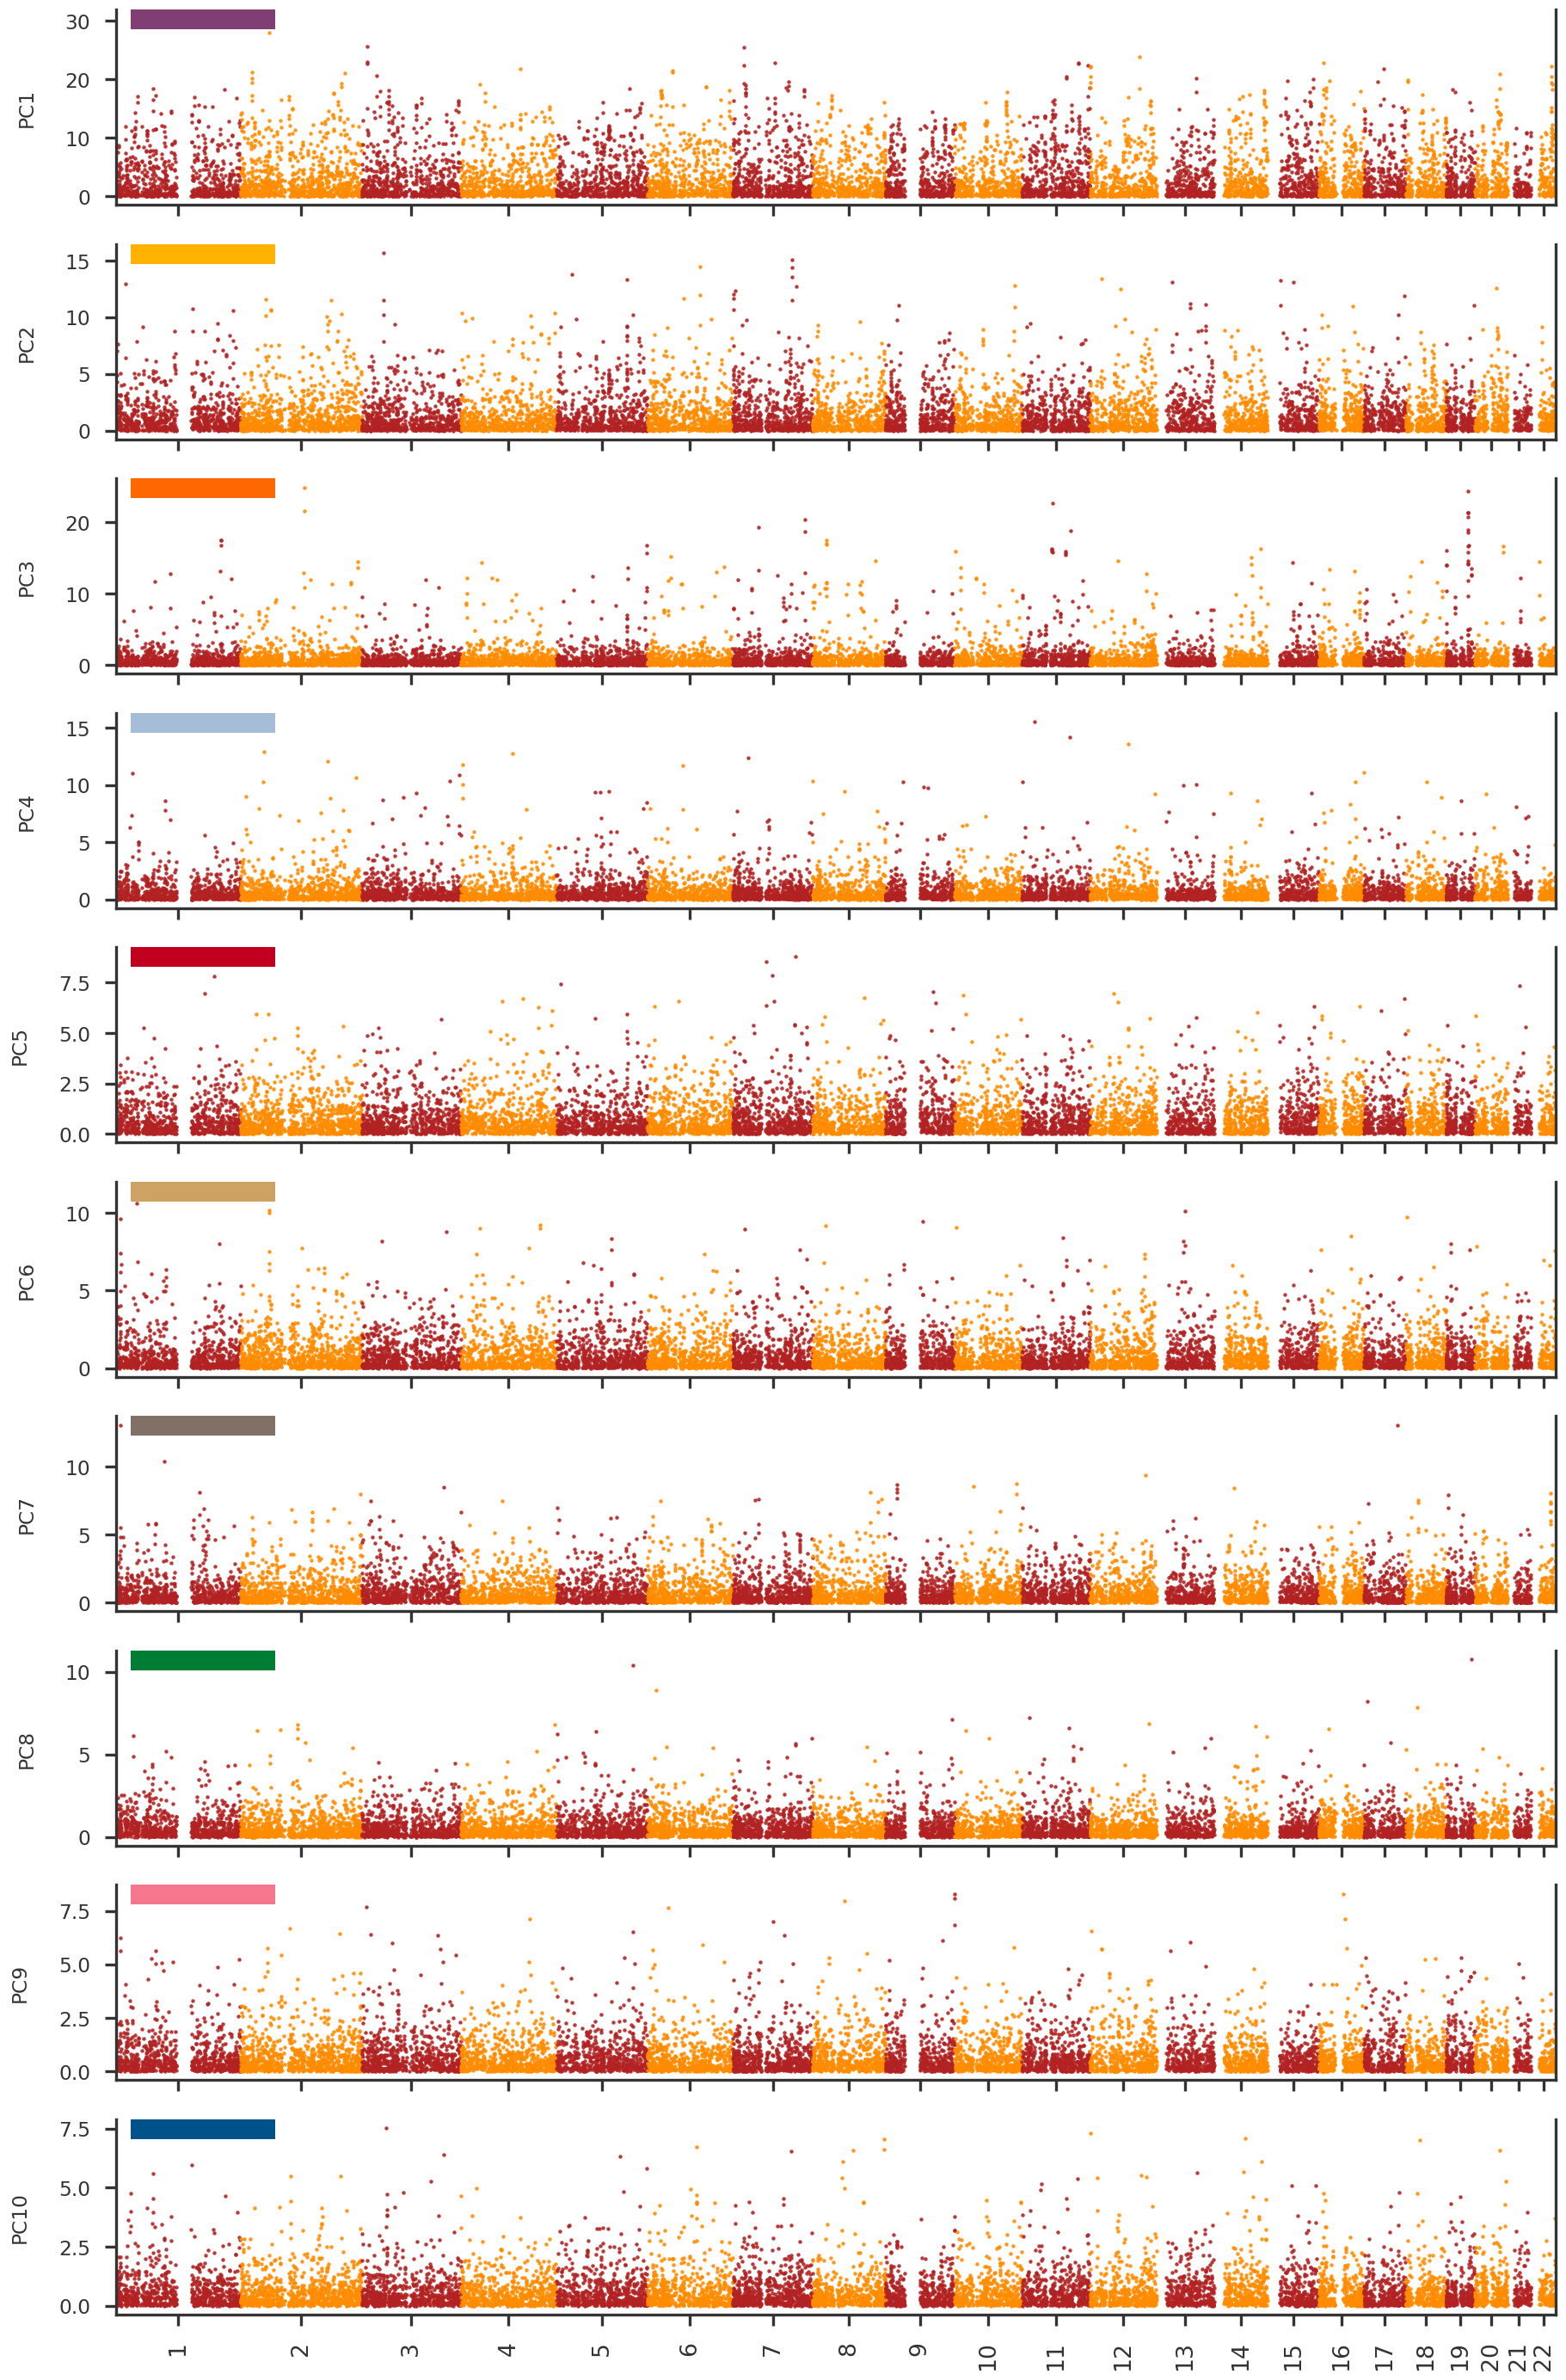

In [29]:
#| label: fig-assoc-variants-to-pcomps
#| fig-cap: "Association of variants with principal components (hidden factors)"

import matplotlib.patches as mpatches

fig = plt.figure(figsize = (18, 2 * npcomp + (npcomp - 1) * 1))

whichmethod = 'nnm_sparse'

for icomp in range(npcomp):
    ax = fig.add_subplot(npcomp, 1, icomp+1)
    pval_data = pval_to_manhattan_data(pvals[whichmethod], icomp)
    showx = True if icomp == npcomp - 1 else False
    plot_manhattan(ax, pval_data, f"PC{icomp + 1}", showx = showx)
    label_rect = ax.add_artist(mpatches.Rectangle((0.01, 0.9), 0.1, 0.1, edgecolor = 'none', facecolor = pcomp_colors[f"{icomp + 1}"], transform = ax.transAxes))

plt.show()